In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=5)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 597 (delta 10), reused 2 (delta 1), pack-reused 569
Receiving objects: 100% (597/597), 57.73 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (298/298), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.29.2
Using datasets v2.12.0
Using accelerate v0.19.0
Using sentencepiece v0.1.99


# 그리디 서치 디코딩

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
model_name = "gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [3]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가합니다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.30%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


In [4]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most popular toys of all time. They


In [5]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home


# 빔 서치 디코딩

In [6]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [7]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [8]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

로그 확률: -86.50


In [9]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the University of California, Santa Cruz, and
published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz,
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.




로그 확률: -65.20


## 텍스트 반복 해결

In [10]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able

로그 확률: -79.02


# 샘플링 방법

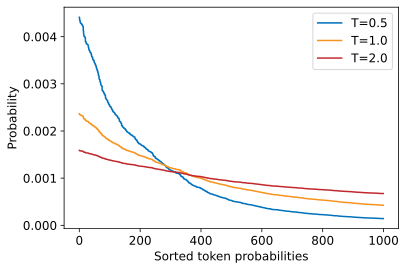

In [11]:
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [12]:
torch.manual_seed(42)

In [13]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Banglington station 21 protagonist Breeboarding Chief Steve Wheslee famously
Speech Jenny Noir portrayed laugh atCONc Nation 6/zin A hawk Turner Dorbecue
WILL Pumpkin mereFebruaryvern stall Snow YoAniamond disse * Runew Endurance MrTL
secured conference flyer zoAccording to journalist MIA KramerJane credentials
Wrestling 317Things.dd Buffer Ty8 Hidden Kimville66 graz Oz at affopy
temporourus RIP Canada famously


In [14]:
torch.manual_seed(42);

In [15]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists, who have been studying the animals for the past 20 years, have
named the unicorns "Unicorn Valley" after the valley in which they live.

"We had never heard of this valley before and it's a bit of a surprise," said
Dr. Jens-Christian Ström, a researcher at the University of Bern in Switzerland,
who led the study. "


# 탑-k 및 뉴클리어스 샘플링

In [16]:
torch.manual_seed(42);

In [17]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [18]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

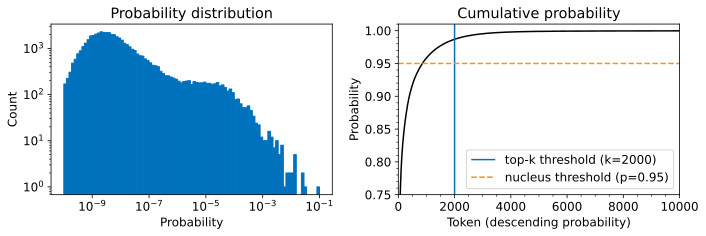

In [19]:
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [20]:
torch.manual_seed(42);

In [21]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam in the low mountains of the Andes, making it hard for
human beings to find them. (Photo by H.K. Kim/AP Images)

An analysis of the findings from the Himalayan Project's expedition into the
Valley of the Unicorn concluded that the unicorns are actually descendants of
wild horses killed by the Indians before their migration to the Americas. The
horses weren


In [22]:
torch.manual_seed(42);

In [23]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam in the same mountains that have given birth to the
world's finest human beings, the indigenous people of Ecuador, and the most
magnificent animal in the Andes mountains: the magnificent and highly endangered
antelope.

In 2006, researchers from the National Institute of Anthropology and History of
the Ministry of Foreign Affairs of Ecuador made the shocking discovery of a herd
of six majestic unicorns living
